0.9713843500672407
0.5668600483892758


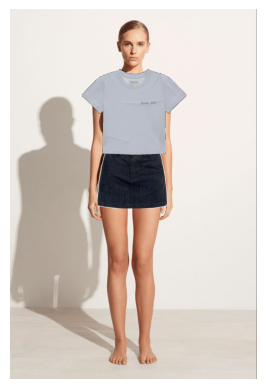

In [22]:
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt
import mediapipe as mp

def load_and_convert_image(image_path, color_space='RGB'):
    """이미지를 불러오고 필요한 색 공간으로 변환합니다."""
    image = cv.imread(image_path, cv.IMREAD_UNCHANGED)
    if color_space == 'RGB':
        image = cv.cvtColor(image, cv.COLOR_BGR2RGB)
    elif color_space == 'RGBA':
        image = cv.cvtColor(image, cv.COLOR_BGRA2RGBA)
    return image

def find_top_extremes(image):
    """상의 이미지에서 최상단 좌우 극단점을 찾습니다."""
    gray = cv.cvtColor(image, cv.COLOR_BGR2GRAY)
    _, binary = cv.threshold(gray, 127, 255, cv.THRESH_BINARY)
    contours, _ = cv.findContours(binary, cv.RETR_EXTERNAL, cv.CHAIN_APPROX_SIMPLE)
    image_center_x = gray.shape[1] // 2
    left_topmost, right_topmost = None, None
    for contour in contours:
        for point in contour:
            x, y = point[0]
            if x < image_center_x and (left_topmost is None or y < left_topmost[1]):
                left_topmost = (x, y)
            elif x >= image_center_x and (right_topmost is None or y < right_topmost[1]):
                right_topmost = (x, y)
    distance = np.linalg.norm(np.array(left_topmost) - np.array(right_topmost))
    return distance, left_topmost, right_topmost

def find_pants_extremes(image):
    """하의 이미지에서 최상단 좌우 극단점을 찾습니다."""
    gray = cv.cvtColor(image, cv.COLOR_BGR2GRAY)
    _, binary = cv.threshold(gray, 127, 255, cv.THRESH_BINARY_INV)
    contours, _ = cv.findContours(binary, cv.RETR_LIST, cv.CHAIN_APPROX_NONE)
    image_center_x = gray.shape[1] // 2
    left_topmost, right_topmost = None, None
    for contour in contours:
        for point in contour:
            x, y = point[0]
            if x < image_center_x and (left_topmost is None or y < left_topmost[1]):
                left_topmost = (x, y)
            elif x >= image_center_x and (right_topmost is None or y < right_topmost[1]):
                right_topmost = (x, y)
    distance = np.sqrt((right_topmost[0] - left_topmost[0])**2 + (right_topmost[1] - left_topmost[1])**2)
    return distance, left_topmost, right_topmost

def calculate_scale_factor_for_top(shoulder_width, top_distance, scale_adjustment=0.45):
    """상의 이미지와 사람의 어깨 너비 사이의 스케일 팩터를 계산합니다."""
    print((shoulder_width * scale_adjustment) / top_distance)
    return (shoulder_width * scale_adjustment) / top_distance

def calculate_scale_factor_for_pants(hip_width, pants_distance, scale_adjustment=1.4):
    """하의 이미지와 사람의 골반 너비 사이의 스케일 팩터를 계산합니다."""
    print((hip_width * scale_adjustment) / pants_distance)
    return (hip_width * scale_adjustment) / pants_distance

def overlay_clothing_on_person(person_image, clothing_image, overlay_position, scale_factor, person_image_shape):
    """계산된 스케일 팩터를 사용하여 사람 이미지 위에 옷 이미지를 오버레이합니다."""
    resized_clothing = cv.resize(clothing_image, None, fx=scale_factor, fy=scale_factor, interpolation=cv.INTER_AREA)
    overlay_x, overlay_y = overlay_position
    image_height, image_width, _ = person_image_shape
    for i in range(resized_clothing.shape[0]):
        for j in range(resized_clothing.shape[1]):
            if resized_clothing[i, j, 3] > 0:  # 알파 채널 체크
                x, y = int(overlay_x + j), int(overlay_y + i)
                if 0 <= x < image_width and 0 <= y < image_height:
                    person_image[y, x, :] = resized_clothing[i, j, :3]
    return person_image

def dress_person_with_clothes(person_image_path, top_image_path, pants_image_path):
    """사람 이미지에 상의와 하의를 모두 입히는 과정을 진행합니다."""
    # 사람 이미지를 불러옵니다.
    person_image = load_and_convert_image(person_image_path, color_space='RGB')
    # 상의와 하의 이미지를 불러옵니다.
    top_image = load_and_convert_image(top_image_path, color_space='RGBA')
    pants_image = load_and_convert_image(pants_image_path, color_space='RGBA')

    top_distance, _, _ = find_top_extremes(top_image)
    pants_distance, _, _ = find_pants_extremes(pants_image)

    # MediaPipe로 포즈 감지
    mp_pose = mp.solutions.pose
    pose = mp_pose.Pose()
    results = pose.process(cv.cvtColor(person_image, cv.COLOR_RGB2BGR))

    if results.pose_landmarks:
        # 하의
        left_hip, right_hip = results.pose_landmarks.landmark[mp_pose.PoseLandmark.LEFT_HIP], results.pose_landmarks.landmark[mp_pose.PoseLandmark.RIGHT_HIP]
        image_height, image_width, _ = person_image.shape
        left_hip_x, left_hip_y = int(left_hip.x * image_width), int(left_hip.y * image_height)
        right_hip_x, right_hip_y = int(right_hip.x * image_width), int(right_hip.y * image_height)
        hip_width = np.sqrt((right_hip_x - left_hip_x)**2 + (right_hip_y - left_hip_y)**2)
        scale_factor = calculate_scale_factor_for_pants(hip_width, pants_distance)
        overlay_x = (left_hip_x + right_hip_x) // 2 - (pants_image.shape[1] * scale_factor) // 2
        overlay_y = left_hip_y - (hip_width * scale_factor)
        person_image = overlay_clothing_on_person(person_image, pants_image, (overlay_x, overlay_y), scale_factor, person_image.shape)

        # 상의
        left_shoulder, right_shoulder = results.pose_landmarks.landmark[mp_pose.PoseLandmark.LEFT_SHOULDER], results.pose_landmarks.landmark[mp_pose.PoseLandmark.RIGHT_SHOULDER]
        image_height, image_width, _ = person_image.shape
        left_shoulder_x, left_shoulder_y = int(left_shoulder.x * image_width), int(left_shoulder.y * image_height)
        right_shoulder_x, right_shoulder_y = int(right_shoulder.x * image_width), int(right_shoulder.y * image_height)
        shoulder_width = np.linalg.norm(np.array([right_shoulder_x, right_shoulder_y]) - np.array([left_shoulder_x, left_shoulder_y]))
        scale_factor = calculate_scale_factor_for_top(shoulder_width, top_distance)
        overlay_x = (left_shoulder_x + right_shoulder_x) // 2 - (top_image.shape[1] * scale_factor) // 2
        overlay_y = min(left_shoulder_y, right_shoulder_y) - (shoulder_width * scale_factor) / 2
        person_image = overlay_clothing_on_person(person_image, top_image, (overlay_x, overlay_y), scale_factor, person_image.shape)
        
    # 결과 표시
    plt.imshow(person_image)
    plt.axis('off')
    plt.show()

# 예제 실행
dress_person_with_clothes('model_F.png', 'clothes/Blue_T.png', 'clothes/blue_skirt.png')